#Titanic Distaster Analysis & Predictions using Python

# Importing the libraries and the data

Importing all the important libraries required.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier,
                             VotingClassifier)
from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict,
                                     StratifiedKFold, learning_curve)
from sklearn.metrics import (confusion_matrix, accuracy_score) 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
from collections import Counter
sns.set(style = 'white' , context = 'notebook', palette = 'deep')
warnings.filterwarnings('ignore', category = DeprecationWarning)
%matplotlib inline

Loading the dataset into enviornment.

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

We will be concatining, the two datasets so that we can handle the data processing. 

In [ ]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [ ]:
dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


First we will try and understand all the columns that are mentioned in the dataset. 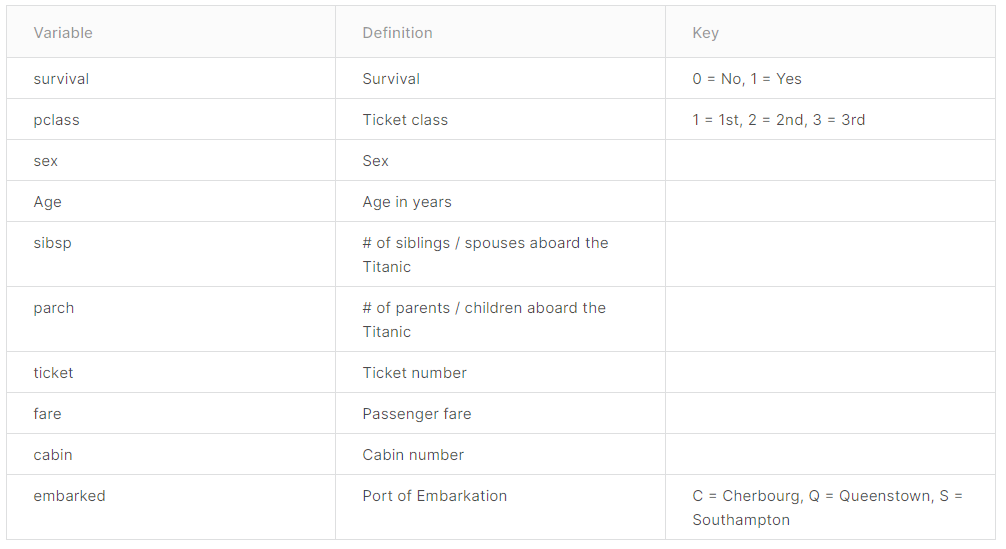

From the website : https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280 we can have a clear understanding of all the variables / features that are mentioned in the dataset. 

Since, the passengerID isn't any fruitful, we will remove it.

In [ ]:
TestPassengerID = test['PassengerId']

Having a look at the dataset. 

In [ ]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Let's have a look at the dataset's value that have missinng values.

In [ ]:
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# Handling the missing data.

To understand the missing data, we need to first find out the amount of missing data in the dataframe.

In [ ]:
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])


According to the website : https://nbviewer.org/github/iphton/Kaggle-Competition/blob/gh-pages/Titanic%20Competition/Notebook/Predict%20survival%20on%20the%20Titanic.ipynb 

The outliers in the data can create a void in the conclusions that we make, so it has to be made sure that the outliers in the data are removed completely.
We have created a function called as detect_outliers, in which we have used the list to mark out the outlier's indexes.
We will be iterating through the features function, using different quartlies and then creating a box-whiskers plot, we can easily point out the outliers.
The outliers which are then detected, can be stored in the list with their indexes as values in them, which can later be removed.

In [ ]:
def detect_outliers(df,n,features):
    #Takes a dataframe df of features and returns a list of the indices
    #corresponding to the observations containing more than n outliers according
    #to the Tukey method.
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                              (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
   
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)  

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])


Once the outliers are removed, we will concating the dataset with removed indexes of outliers.

In [ ]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

Let's try to visualize the categorical values in the dataset. 

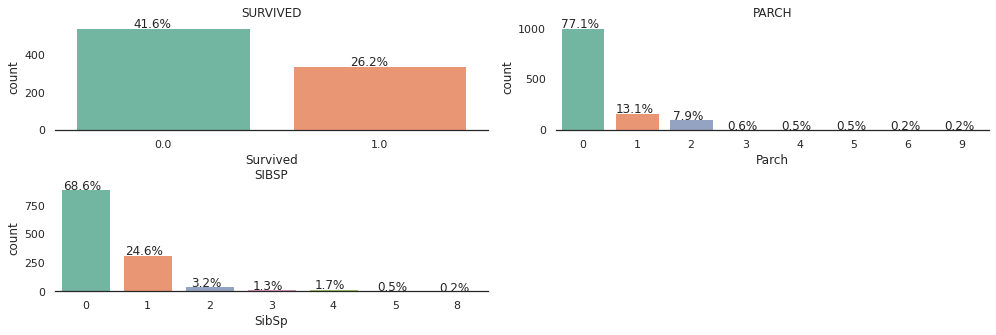

In [ ]:
# Making a list of all categorical variables

plt.figure(figsize=(14,20))

sns.set_theme(style="white") 
cols=['Survived','Parch','SibSp']
for i, variable in enumerate(cols):
                     plt.subplot(9,2,i+1)
                     order = dataset[variable].value_counts(ascending=False).index   
                     #sns.set_palette(list_palette[i]) # to set the palette
                     sns.set_palette('Set2')
                     ax=sns.countplot(x=dataset[variable], data=dataset )
                     sns.despine(top=True,right=True,left=True) # to remove side line from graph
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(dataset[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')
                     plt.tight_layout()
                     plt.title(cols[i].upper())
                                     

Finding the correlation between and amongst the feature can be one important task in order to realize the data type we are dealing with. 

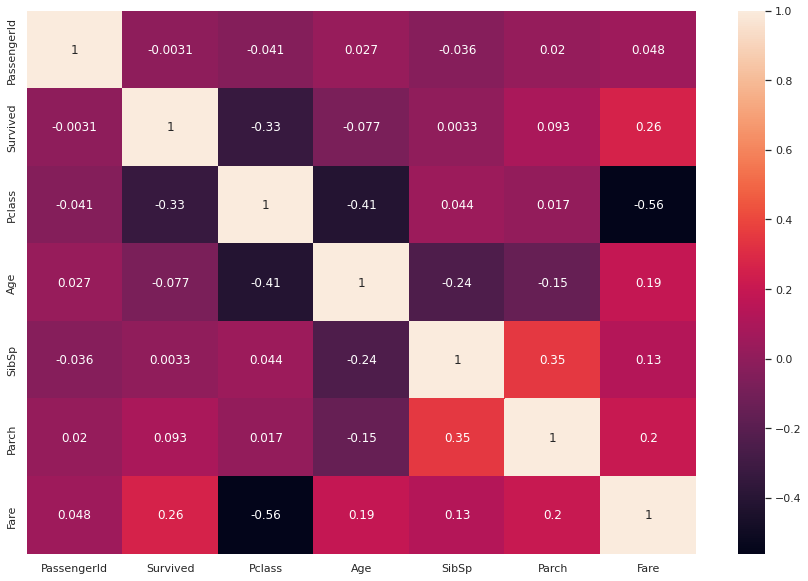

In [ ]:
sns.set_palette(sns.color_palette("Set2", 8))
plt.figure(figsize=(15,10))
sns.heatmap(dataset.corr(),annot=True)
plt.show()

Let's try to visualize how much has age affected the rate of survivial. 

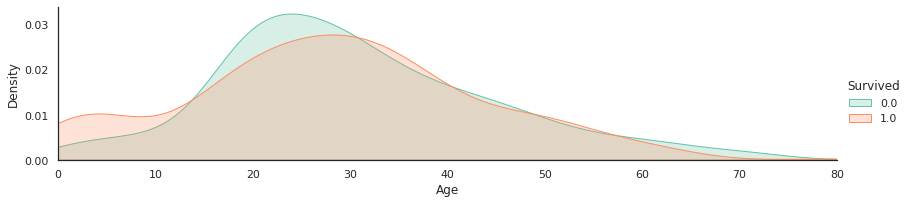

In [ ]:
fig = sns.FacetGrid(dataset, hue = 'Survived', aspect = 4)
fig.map(sns.kdeplot, 'Age' , shade = True)
fig.set(xlim = (0, dataset['Age'].max()))
fig.add_legend()

We can see that age from 11 - 35 has high density for failure to survive.


Since it is hard to deal with the string values, and sex is a categorical value, we will be using map function to map male = 0, female = 1, since the hiughest rate of survival in titanic disaster is female.

In [ ]:
dataset['Sex'] = dataset['Sex'].map({'male':0,'female' : 1})

Let's explore all the valules of survived feature, with the features having categorical values.

In [ ]:
def plot(x,target='Survived'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title(f'Distribution of {x} \n Not survived',fontsize=12,fontweight='bold')
    sns.distplot(dataset[(dataset[target] == 0)][x],ax=axs[0,0],color='teal')
    axs[0, 1].set_title(f"Distribution of {x}\ Survived",fontsize=12,fontweight='bold')
    sns.distplot(dataset[(dataset[target] == 1)][x],ax=axs[0,1],color='orange')
    axs[1,0].set_title(f'Boxplot of {x} w.r.t Survived',fontsize=12,fontweight='bold')
    
    line = plt.Line2D((.1,.9),(.5,.5), color='grey', linewidth=1.5,linestyle='--')
    fig.add_artist(line)
   
    sns.boxplot(dataset[target],dataset[x],ax=axs[1,0],palette='gist_rainbow',showmeans=True)
    axs[1,1].set_title(f'Boxplot of {x} w.r.t Survived -  Without outliers',fontsize=12,fontweight='bold')
    sns.boxplot(dataset[target],dataset[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow',showmeans=True) #turning off outliers from boxplot
    sns.despine(top=True,right=True,left=True) # to remove side line from graph
    plt.tight_layout(pad=4)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.

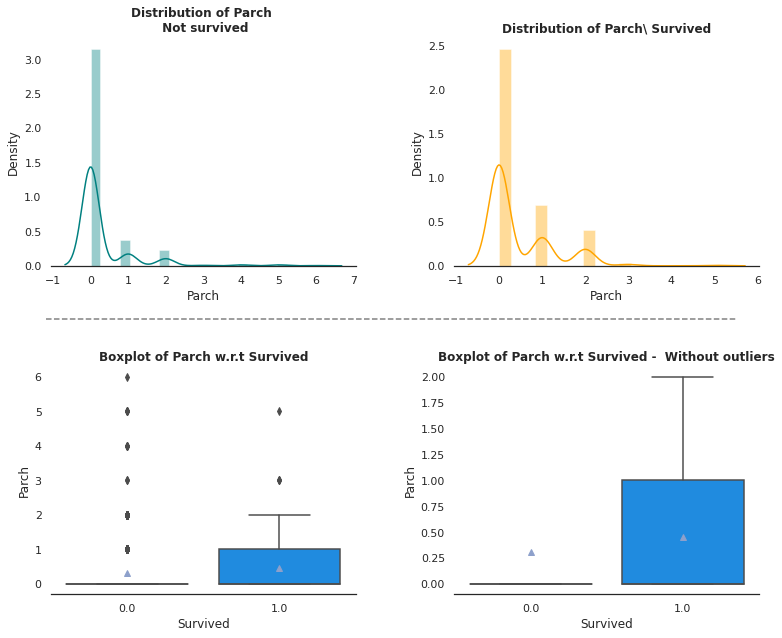

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.

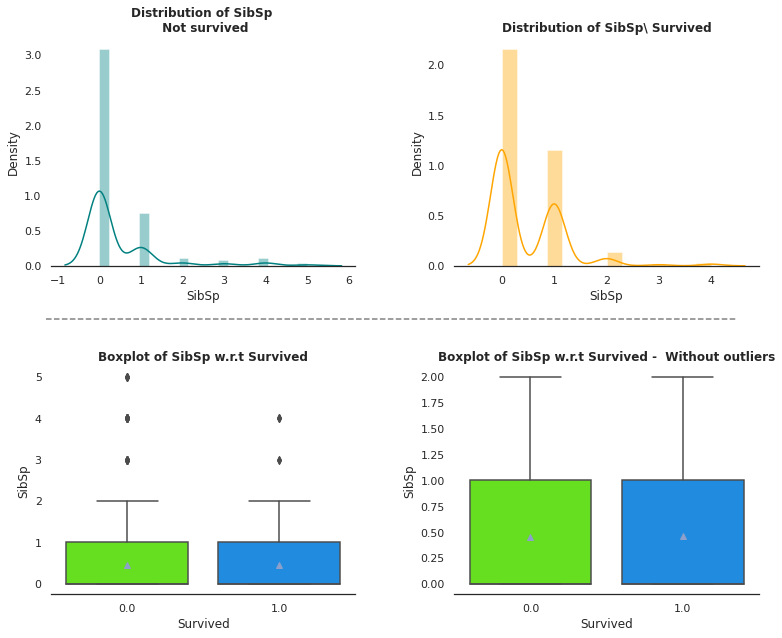

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.

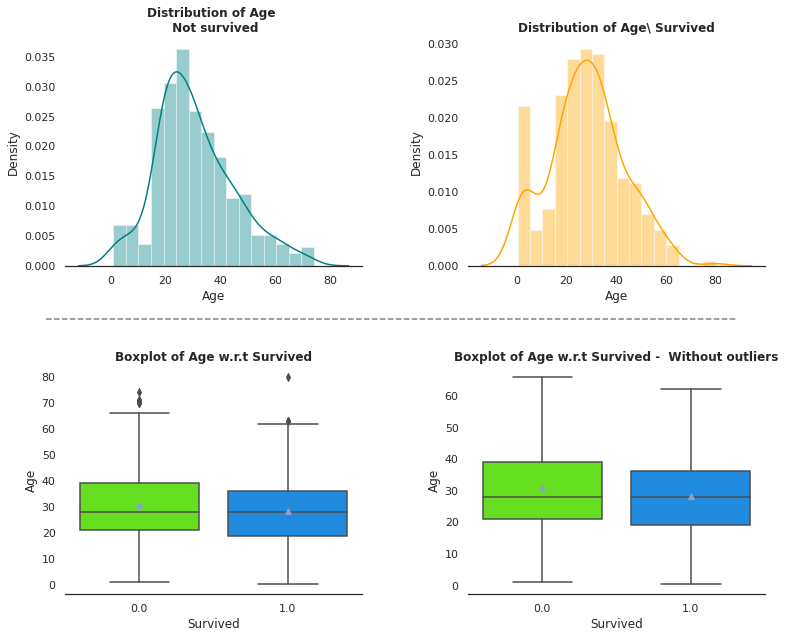

In [ ]:
list_col=  ['Parch','SibSp','Age']
for j in range(len(list_col)):
   plot(list_col[j])
   


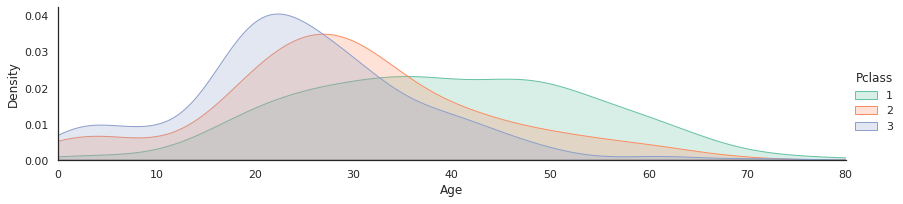

In [ ]:
facet = sns.FacetGrid(dataset, hue="Pclass", aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

In [ ]:
def AgeImpute(df):
    Age = df[0]
    Pclass = df[1]
    
    if pd.isnull(Age):
        if Pclass == 1: return 37
        elif Pclass == 2: return 29
        else: return 24
    else:
        return Age

# Age Impute
dataset['Age'] = dataset[['Age' , 'Pclass']].apply(AgeImpute, axis = 1)

If we look at the Fare feature, we can see we have 1 null value, lets gp ahead and replace it with the median of the FARE column.

In [ ]:
dataset['Fare'].isna().sum()

1

In [ ]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [ ]:
'''
# convert Sex into categorical value 0 for male and 1 for female
sex = pd.get_dummies(dataset['Sex'], drop_first = True)
dataset = pd.concat([dataset,sex], axis = 1)

# After now, we really don't need to Sex features, we can drop it.
dataset.drop(['Sex'] , axis = 1 , inplace = True)
'''

"\n# convert Sex into categorical value 0 for male and 1 for female\nsex = pd.get_dummies(dataset['Sex'], drop_first = True)\ndataset = pd.concat([dataset,sex], axis = 1)\n\n# After now, we really don't need to Sex features, we can drop it.\ndataset.drop(['Sex'] , axis = 1 , inplace = True)\n"

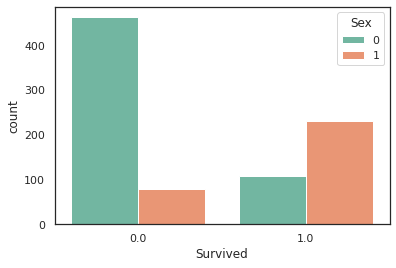

In [ ]:
# using countplot to estimate amount
sns.countplot(data = train , x = 'Survived' , hue = 'Sex')

In [ ]:
# let's see the percentage
train[["Sex","Survived"]].groupby('Sex').mean()# let's see the percentage

,Survived
Sex,
female,0.747573
male,0.190559


We will use the data from the Embarked class, and the idea is to replace the null values with the one value that has most repeated values.

In [ ]:
print(dataset.groupby(['Embarked'])['PassengerId'].count())
dataset.groupby(['Embarked']).mean()

Embarked
C    270
Q    123
S    904
Name: PassengerId, dtype: int64


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Embarked,,,,,,,,
C,690.655556,0.553571,1.851852,0.418519,31.242296,0.400000,0.370370,62.336267
Q,668.593496,0.389610,2.894309,0.487805,25.963415,0.341463,0.113821,12.409012
S,645.971239,0.339117,2.347345,0.316372,28.973175,0.484513,0.409292,26.296450


As we can see that 'S' has most values in the dataset, we will be counting the null values and replacing the null values with 'S'.

In [ ]:
print(dataset["Embarked"].isnull().sum()) 
dataset["Embarked"] = dataset["Embarked"].fillna("S")

2


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



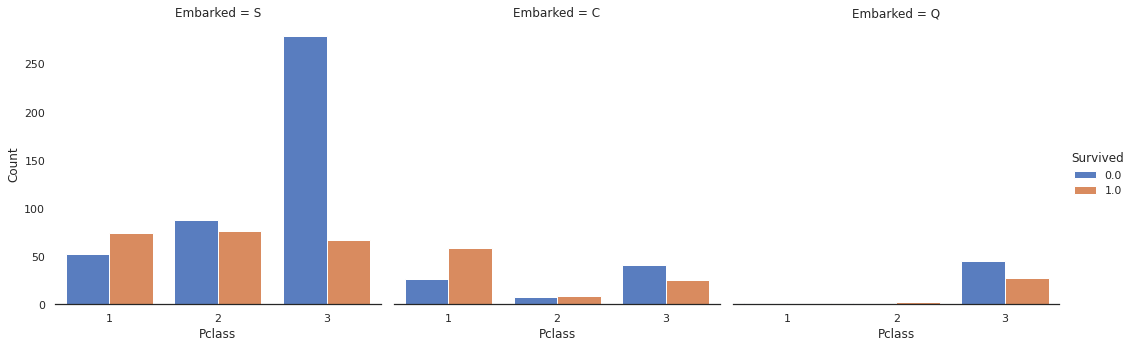

In [ ]:
# Counting passenger based on Pclass and Embarked 
Embarked_Pc = sns.factorplot("Pclass", col="Embarked",  data=dataset,
                   size=5, kind="count", palette="muted", hue = 'Survived')

Embarked_Pc.despine(left=True)
Embarked_Pc = Embarked_Pc.set_ylabels("Count")

In [ ]:
# create dummy variable
embarked = pd.get_dummies(dataset['Embarked'], drop_first = True)
dataset = pd.concat([dataset,embarked], axis = 1)

# after now, we don't need Embarked coloumn anymore, so we can drop it.
dataset.drop(['Embarked'] , axis = 1 , inplace = True)

From the famous website **Towardsdatascience** : https://towardsdatascience.com/kaggle-titanic-machine-learning-model-top-7-fa4523b7c40 
it states that we can't just drop the name of passenger's in the dataset, as it contains fruitful information which can bve used to yeild promising results in the end.
The title of the name can give us many useful information, which can help us understand the gender, age and many more. 
We will be using pandas split function to get the title of the name, but it can also be done using Regex [ Regular Expressions.] 

In [ ]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [ ]:
print(dataset.groupby('Title')['Age'].mean())

Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              42.750000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           7.643000
Miss            22.261137
Mlle            24.000000
Mme             24.000000
Mr              30.926295
Mrs             35.898477
Ms              26.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64


In [ ]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess',
                                             'Capt', 'Col','Don', 'Dr', 
                                             'Major', 'Rev', 'Sir', 'Jonkheer',
                                             'Dona'], 'Rare')

dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})

dataset["Title"] = dataset["Title"].astype(int)

# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



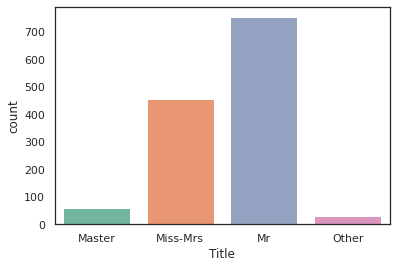

In [ ]:
# viz counts the title coloumn
sns.countplot(dataset["Title"]).set_xticklabels(["Master","Miss-Mrs","Mr","Other"]);

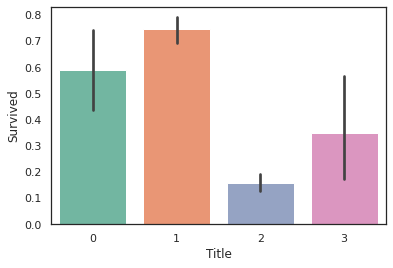

In [ ]:
# Let's see, based on title what's the survival probability
sns.barplot(x='Title', y='Survived', data=dataset);

We can understand if the person was alone, or was with family, it could really help us unbderstand that having a big/small family or being alonbe affected the survival rate or it did not. 

In [ ]:
dataset["Famize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset.drop(labels = ["SibSp",'Parch'], axis = 1, inplace = True)

Once all the handling of data is done, we can now drop the features that we do not require.

In [ ]:
dataset.drop(labels = ["Ticket",'Cabin','PassengerId'], axis = 1, 
             inplace = True)

# Creating a predictive model.

Spliting the dataset into train model and test model, since we had concated them before, we will need to seperate them again.

In [ ]:
train = dataset[:len(train)]
test = dataset[len(train):]
test.drop(labels=["Survived"],axis = 1,inplace = True)

Y_train = train["Survived"].astype(int)
X_train = train.drop(labels = ["Survived"],axis = 1)

K_fold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We will be using Random Forest Classifier since it is widely used in predictive models with such cases.

In [ ]:
RFC_model = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(RFC_model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.76404494 0.92045455 0.75       0.79545455 0.88636364 0.875
 0.81818182 0.72727273 0.80681818 0.86363636]


82.07

We have achieved the accuracy of 82.07%, lets noe tune the hyperparameters, and see if we can improve the accuracy of the model.

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 4, 16],
              "n_estimators" :[100,200,300,400],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_ * 100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


84.33861082737486

# References

The references used for the code are from following websites : 
1.  https://github.com/Msanjayds/Kaggle_Projects/blob/master/1.%20Titanic%20Survival%20Prediction/Titanic_challenge.ipynb 

2.   https://nbviewer.org/github/iphton/Kaggle-Competition/blob/gh-pages/Titanic%20Competition/Notebook/Predict%20survival%20on%20the%20Titanic.ipynb 

3. https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280

